# Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/ANDL/Homework_2

/gdrive/MyDrive/ANDL/Homework_2


# Libraries

In [4]:
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18913 sha256=a9e7a9837b6aad3a26aa9f7bb0119e2cf0440c35649f82e3a8cec4ad3fdbb9ad
  Stored in directory: /root/.cache/pip/wheels/ac/13/2d/3de7c76f618a8d162884ac5b726a8c2242ad88afa370f1e62f
Successfully built keras-self-attention


In [5]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [6]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Data

In [7]:
X_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [8]:
df = pd.DataFrame()

for t in range(0, 2429):
  temp_df = pd.DataFrame(X_train[t, :, :])
  temp_df["serie"] = t
  temp_df["target"] = y_train[t]
  df = pd.concat([df, temp_df])
df = df.rename(columns={0:"x0", 1:"x1", 2:"x2", 3:"x3", 4:"x4", 5:"x5"})
print(df)

          x0        x1        x2        x3        x4       x5  serie  target
0   17.59700   8.17130  -1.78420 -19.70600  -9.71350 -61.8870      0       0
1    0.22974  -5.89560  16.83700   5.03900   2.43320  58.9140      0       0
2  -29.65400 -21.29600  29.10300  -0.47503  75.39100  10.6650      0       0
3  -59.21000 -29.56500  17.97100 -45.60600  19.41200 -43.0140      0       0
4  -72.06400 -25.85500   0.46536 -59.15100 -29.10500 -11.9130      0       0
..       ...       ...       ...       ...       ...      ...    ...     ...
31   3.51190  -1.03240  -1.69900   4.15790   2.75430   5.9823   2428      11
32   0.70853  -0.94622  -1.91760   2.09480  -4.76750   7.4118   2428      11
33   0.20638   1.02870  -0.92512  -0.71633   1.73330   4.7638   2428      11
34   4.14290   1.09390  -0.18921   1.14100   0.93441   4.1742   2428      11
35  -1.55450  -1.21210   1.07050   1.32720   2.40100   8.4550   2428      11

[87444 rows x 8 columns]


In [9]:
df.head(1000)

,x0,x1,x2,x3,x4,x5,serie,target
0,17.59700,8.1713,-1.784200,-19.70600,-9.7135,-61.887,0,0
1,0.22974,-5.8956,16.837000,5.03900,2.4332,58.914,0,0
2,-29.65400,-21.2960,29.103000,-0.47503,75.3910,10.665,0,0
3,-59.21000,-29.5650,17.971000,-45.60600,19.4120,-43.014,0,0
4,-72.06400,-25.8550,0.465360,-59.15100,-29.1050,-11.913,0,0
...,...,...,...,...,...,...,...,...
23,-4.56440,4.7574,1.666500,30.24900,3.5516,72.818,27,0
24,2.68540,9.7023,6.918400,-19.56100,-50.0060,-22.576,27,0
25,11.47700,8.9163,20.230000,-3.72380,66.5000,47.156,27,0
26,15.94500,3.9105,14.408000,25.17500,8.3458,87.464,27,0


In [10]:
window = 36
stride = 36

In [11]:
def build_sequences(df, window=36, stride=36):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for s in df['serie'].unique():
        # Take only meaningful features
        temp = df[df['serie'] == s][['x0', 'x1', 'x2', 'x3', 'x4', 'x5']].values
        # Save the label
        label = df[df['serie'] == s]['target'].values[0]
        # Compute padding length
        #padding_len = window - len(temp)%window
        # Create padding and concatenate it
        #padding = np.zeros((padding_len,6), dtype='float64')
        #temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [12]:
X_train, y_train = build_sequences(df, window, stride)
X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train ,random_state=104, test_size=0.15, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2064, 36, 6), (2064,), (365, 36, 6), (365,))

In [14]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2064, 36, 6), (2064, 12), (365, 36, 6), (365, 12))

In [17]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [34]:
def build_1DCNN_classifier(input_shape, classes):
    n_feature_maps = 64

    input_layer = tfkl.Input(input_shape)

    # BLOCK 1

    conv_x = tfkl.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

        # expand channels for the sum
    shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = tfkl.BatchNormalization()(shortcut_y)

    output_block_1 = tfkl.add([shortcut_y, conv_z])
    output_block_1 = tfkl.Activation('relu')(output_block_1)

        # BLOCK 2

    conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

        # expand channels for the sum
    shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = tfkl.BatchNormalization()(shortcut_y)
    output_block_2 = tfkl.add([shortcut_y, conv_z])
    output_block_2 = tfkl.Activation('relu')(output_block_2)

        # BLOCK 3

    conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
    shortcut_y = tfkl.BatchNormalization()(output_block_2)

    output_block_3 = tfkl.add([shortcut_y, conv_z])
    output_block_3 = tfkl.Activation('relu')(output_block_3)

        # FINAL

    gap_layer = tfkl.GlobalAveragePooling1D()(output_block_3)

    output_layer = tfkl.Dense(classes, activation='softmax', kernel_initializer = tfk.initializers.GlorotUniform(seed)
    ,kernel_regularizer=tfk.regularizers.L1(0.01),
                     activity_regularizer=tfk.regularizers.L2(0.01))(gap_layer)

    model = tfk.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [35]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d_35 (Conv1D)             (None, 36, 64)       3136        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 36, 64)      256         ['conv1d_35[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 36, 64)       0           ['batch_normalization_36[0]

In [36]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
15/15 [==============================] - 8s 327ms/step - loss: 3.6885 - accuracy: 0.3500 - val_loss: 3.9914 - val_accuracy: 0.2415 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 5s 352ms/step - loss: 3.0302 - accuracy: 0.4733 - val_loss: 3.8838 - val_accuracy: 0.3478 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - 6s 373ms/step - loss: 2.6928 - accuracy: 0.5337 - val_loss: 3.3203 - val_accuracy: 0.4251 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 5s 358ms/step - loss: 2.4857 - accuracy: 0.5622 - val_loss: 3.0035 - val_accuracy: 0.4976 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 5s 327ms/step - loss: 2.3309 - accuracy: 0.5870 - val_loss: 2.8193 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 6/200
15/15 [==============================] - 6s 382ms/step - loss: 2.1738 - accuracy: 0.6047 - val_loss: 2.6933 - val_accuracy: 0.4638 - lr: 0.0010
Epoch 7/200
15/15 [==============================] - 5s 301ms/st

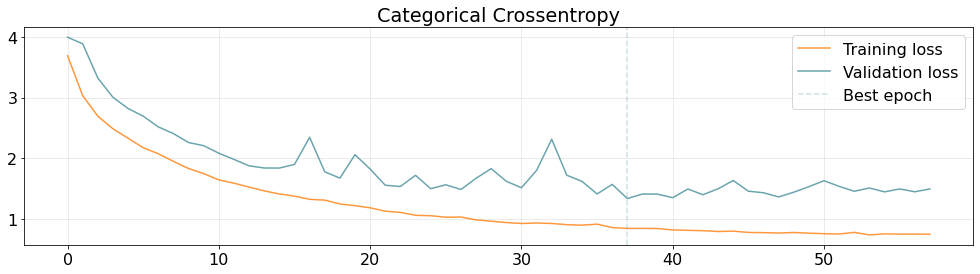

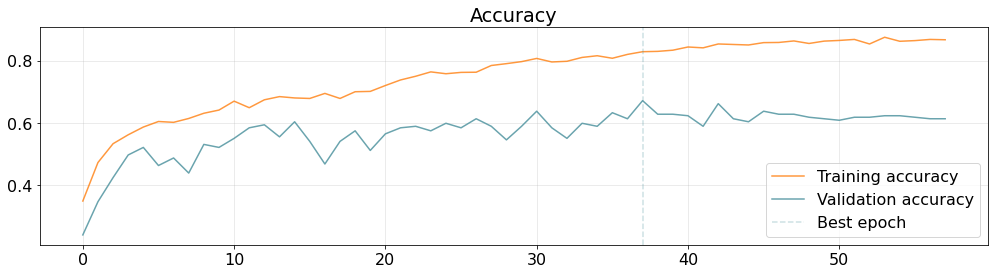

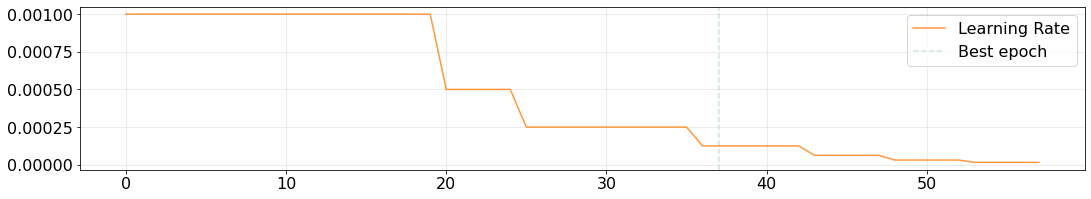

In [37]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [39]:
model.save('new_df/BiLSTM/new_df_rete_leo')
# model = tfk.models.load_model('BiLSTM')

In [40]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

12/12 [==============================] - 1s 25ms/step


(365, 12)

Accuracy: 0.6795
Precision: 0.5925
Recall: 0.5076
F1: 0.5242


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


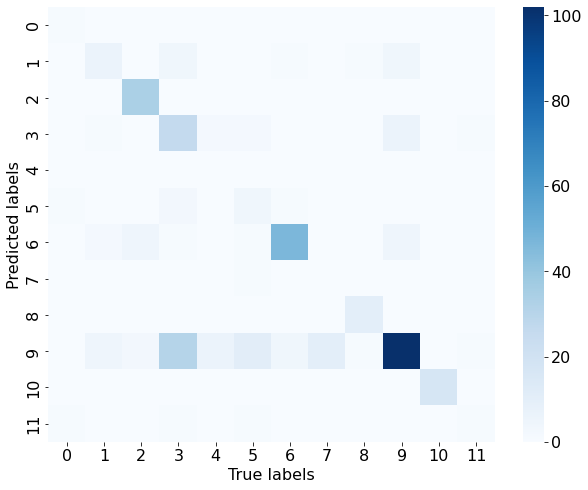

In [41]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()